<h1 style="color:red; font-size: 40px; font-weight: bold;">
Time Series Analysis & Forecasting for Stock Market
</h1>

<h1 style="color:blue; font-size: 30px; font-weight: bold;">
About the Dataset
</h1>
The dataset contains **Apple Incorporated (AAPL) stock price data from 1980 to 2024**, with over 10,000+ daily records.
It includes key financial indicators like:
-**Date**: The trading date.

-**Open, High, Low, Close**: Prices of Apple stock during each trading day.

-**Volume**: Total number of shares traded.

-**Change %**: Daily percentage change in the closing price.

This dataset provides a 40+ year historical view of Apple’s stock performance, making it ideal for time series analysis and forecasting to understand trends, volatility, and future price movements.

<h1 style="color:blue; font-size: 30px; font-weight: bold;">
EDA
</h1>

### 1.Import Libraries

In [44]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Display settings
# Use new style name if available
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')  # fallback

%matplotlib inline


#### This step imports all the libraries for data handling, visualization, and time series decomposition.

### 2.Load and Inspect Data

In [48]:
# Load Excel file
file_path = "D:/Internship/Zidio Development/Apple(1980-2024).xlsx"
df = pd.read_excel(file_path)

# Show basic info
print(df.head())
print(df.info())
print(df.describe())


         Date    Open   Close    High     Low     Vol. Change %
0  03/27/2024  170.30  173.31  173.58  170.14   59.11M   0.0212
1  03/26/2024  170.01  169.71  171.41  169.65   57.22M  -0.0067
2  03/25/2024  170.37  170.85  171.94  169.46   54.21M  -0.0083
3  03/22/2024  171.76  172.28  173.05  170.06   71.16M   0.0053
4  03/21/2024  177.05  171.37  177.49  170.84  106.18M  -0.0409
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10911 entries, 0 to 10910
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      10911 non-null  object 
 1   Open      10911 non-null  float64
 2   Close     10911 non-null  float64
 3   High      10911 non-null  float64
 4   Low       10911 non-null  float64
 5   Vol.      10911 non-null  object 
 6   Change %  10911 non-null  object 
dtypes: float64(4), object(3)
memory usage: 596.8+ KB
None
               Open         Close          High           Low
count  10911.000000  10911.000000  1

#### Loading the dataset and check the first few rows, data types, and summary statistics.
- The dataset spans multiple years of Apple’s stock data, with 10,911 daily records.
- Data types are mostly correct for price columns, but `Date`, `Vol.`, and `Change %` require preprocessing.
- The wide range in `Open`, `Close`, `High`, and `Low` indicates stock splits and long historical data.
- Volume data is in millions (M) or other suffixes, so we will clean this column later for numerical analysis.

### 3.Data Cleaning

In [50]:
# Rename columns for consistency
df.rename(columns={'Price':'Close','Vol.':'Volume','Change %':'ChangePct'}, inplace=True)

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# Sort by date
df = df.sort_values('Date')

# Convert numeric columns
for col in ['Close','Open','High','Low']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',','').astype(float)

# Clean Volume
def parse_vol(x):
    if pd.isna(x): return np.nan
    s=str(x).strip()
    mult=1
    if s.endswith('M'): mult=1_000_000; s=s[:-1]
    elif s.endswith('K'): mult=1_000; s=s[:-1]
    elif s.endswith('B'): mult=1_000_000_000; s=s[:-1]
    s=s.replace(',','')
    try: return float(s)*mult
    except: return np.nan

if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].apply(parse_vol)

# Set index
df.set_index('Date', inplace=True)
df.head()


,Open,Close,High,Low,Volume,ChangePct
Date,,,,,,
1980-12-12,0.13,0.13,0.13,0.13,469030000.0,-0.9988
1980-12-15,0.12,0.12,0.12,0.12,175880000.0,-0.0769
1980-12-16,0.11,0.11,0.11,0.11,105730000.0,-0.0833
1980-12-17,0.12,0.12,0.12,0.12,86440000.0,0.0909
1980-12-18,0.12,0.12,0.12,0.12,73450000.0,0


#### Cleans columns, converts data types, and sets the Date column as the index for time series analysis.
- Data is cleaned and sorted from 1980 to 2024.
- Volume is successfully converted to numeric format (e.g., 59.11M → 59,110,000).
- All price columns are now float values, and `Date` is the time series index.

### 4.Basic Statistics

In [52]:
#Statistical summary
print("Statistical summary")
print(df.describe())

# Check for missing values
print("Checking for missing values")
print(df.isna().sum())

Statistical summary
               Open         Close          High           Low        Volume
count  10911.000000  10911.000000  10911.000000  10911.000000  1.091100e+04
mean      20.941355     20.955370     21.167731     20.723051  3.200811e+08
std       43.502230     43.539722     43.971490     43.061421  3.365076e+08
min        0.050000      0.050000      0.050000      0.050000  1.390000e+06
25%        0.300000      0.300000      0.300000      0.290000  1.147250e+08
50%        0.520000      0.520000      0.530000      0.510000  2.073300e+08
75%       19.305000     19.300000     19.530000     19.125000  4.000150e+08
max      198.020000    198.110000    199.620000    197.000000  7.430000e+09
Checking for missing values
Open         0
Close        0
High         0
Low          0
Volume       0
ChangePct    0
dtype: int64


#### Check overall data distribution and identify missing values
- The dataset is complete with no missing values.
- The wide price range indicates significant historical changes, likely due to stock splits and Apple’s growth over time.

### 5.Visualize Closing Price

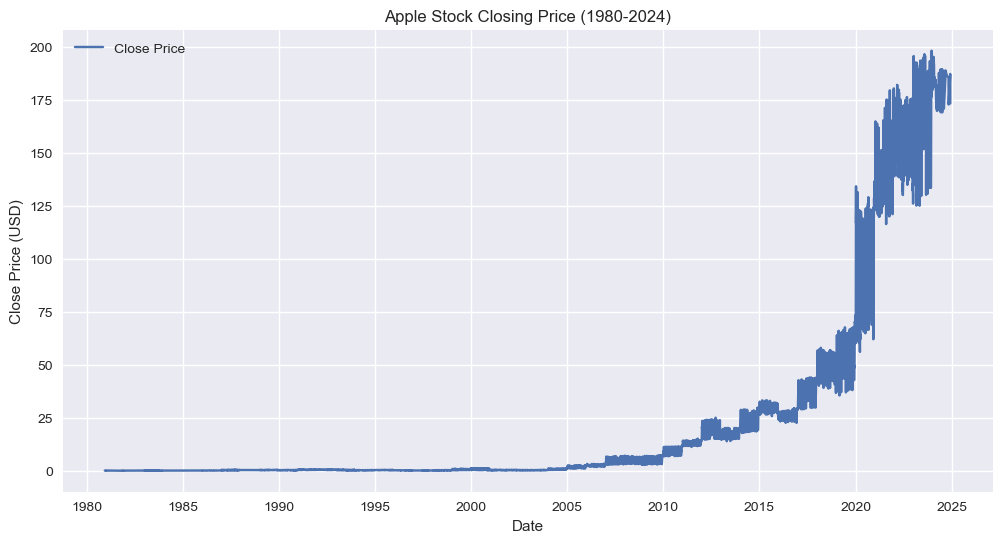

In [56]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Apple Stock Closing Price (1980-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

#### Ploting the closing price trend over the entire dataset.
- Apple’s stock shows exponential growth, especially after 2005.
- This confirms strong long-term uptrend and justifies deeper time series analysis.

### 6.Moving Averages

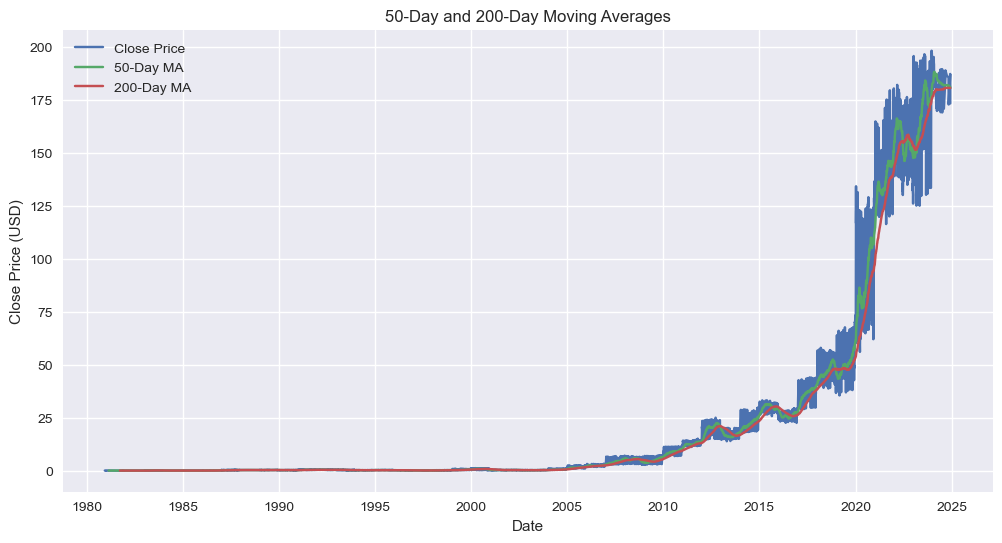

In [62]:
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-Day MA')
plt.plot(df['MA200'], label='200-Day MA')
plt.title('50-Day and 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

#### Adds 50-day and 200-day moving averages to identify medium and long-t
- 50-day and 200-day moving averages show the stock’s medium and long-term trends.
- When the 50-day MA stays above the 200-day MA, it shows strong upward momentum.
- These moving averages help smooth out noise and confirm the overall growth pattern in Apple’s stock.

### 7.Candlestick Chart 

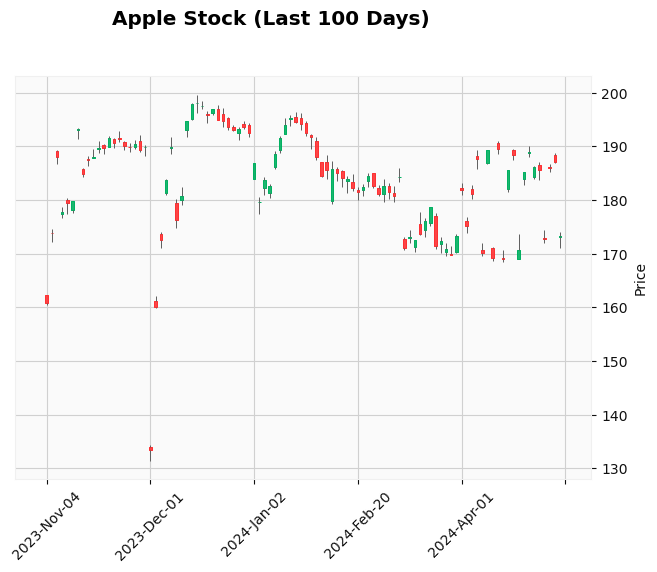

In [64]:
mpf.plot(df[-100:], type='candle', title='Apple Stock (Last 100 Days)', style='yahoo')

#### Displays candlestick chart for the last 100 days.
- Apple stock had both rising (green) and falling (red) days in the last 100 days.
- This chart helps us understand **how the price changes every day**, not just the closing price.
- **Green candles:** Closing price was higher than the opening price (stock price went up that day).
- **Red candles:** Closing price was lower than the opening price (stock price went down that day).
- The thin lines (wicks) show the highest and lowest price of that day.
- The thick part (body) shows the opening and closing prices.

### 8.Decomposition (Trend, Seasonality, Residuals)

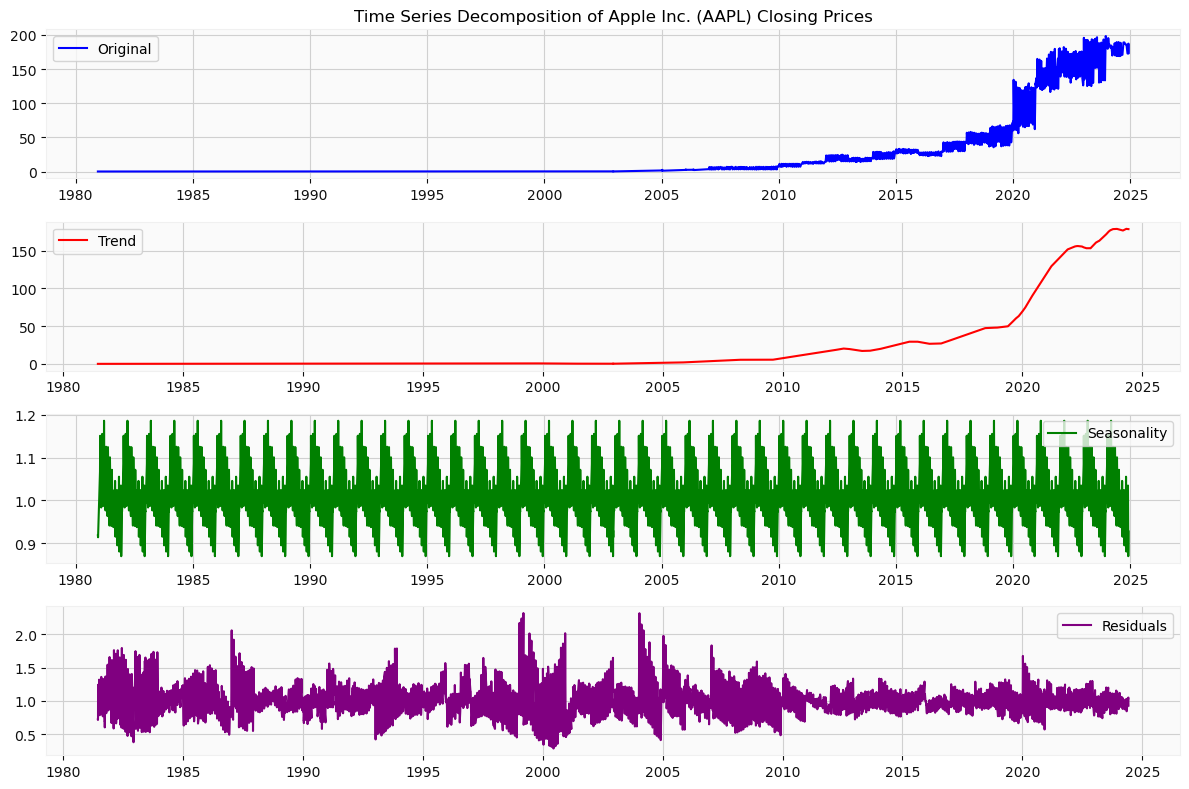

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(data['Close'], model='multiplicative', period=365)

trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid  # note: 'resid', not 'residual'

plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(data['Close'], label='Original', color='blue')
plt.legend(loc='best')
plt.title('Time Series Decomposition of Apple Inc. (AAPL) Closing Prices')

plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resid, label='Residuals', color='purple')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#### Decomposes the series into trend, seasonal, and residual components.
1. **Trend (Red Line):**  
   - Shows the long-term direction of the stock price.
   - Apple’s stock has shown **strong and steady growth**, especially after 2010, with a sharp rise from 2020 onwards.
2. **Seasonality (Green Line):**  
   - Displays repeating patterns over time, such as yearly or monthly fluctuations.
   - Apple stock shows **small seasonal patterns**, but the trend dominates.
3. **Residuals (Purple Line):**  
   - Represents random noise or variations not explained by trend or seasonality.
   - Residuals show some volatility, especially during **major market events**.

### 9.Correlation Analysis

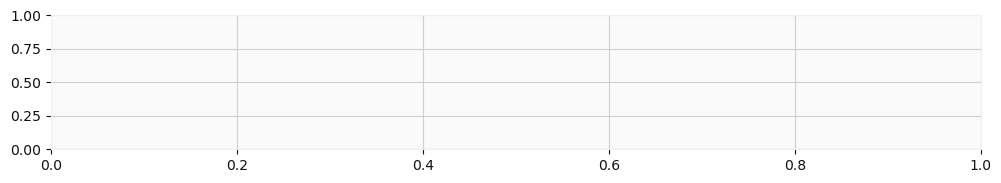

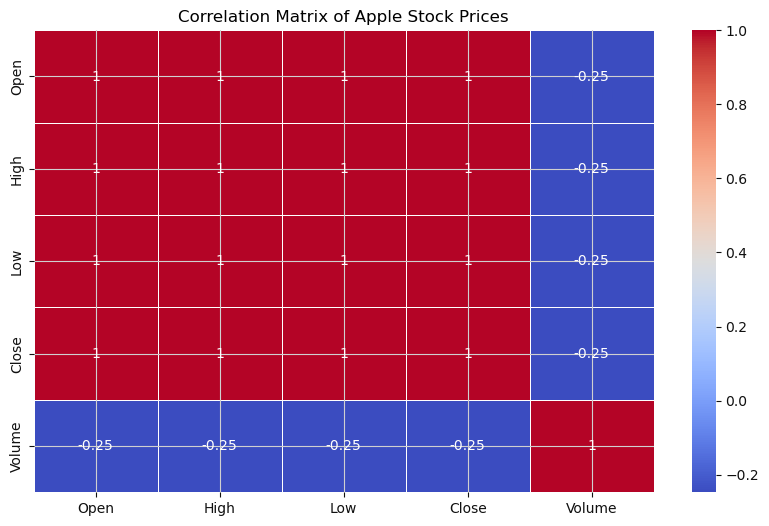

In [70]:
correlation_matrix = df[['Open','High','Low','Close','Volume']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Apple Stock Prices')
plt.show()

#### Displays correlation among price-related variables.
- `Open`, `High`, `Low`, and `Close` have a **very strong positive correlation (close to 1)**.  
  This is expected since these prices move together on most trading days.
- `Volume` shows a **weak negative correlation (around -0.25)** with price variables.  
  This means that high trading volume does not always mean higher prices.

### 10.Volatility Analysis

#### Volatility analysis measures how much a stock's price changes continuously or goes up and down over time.
-High volatility means the price changes a lot (higher risk).

-Low volatility means the price is more stable (lower risk).

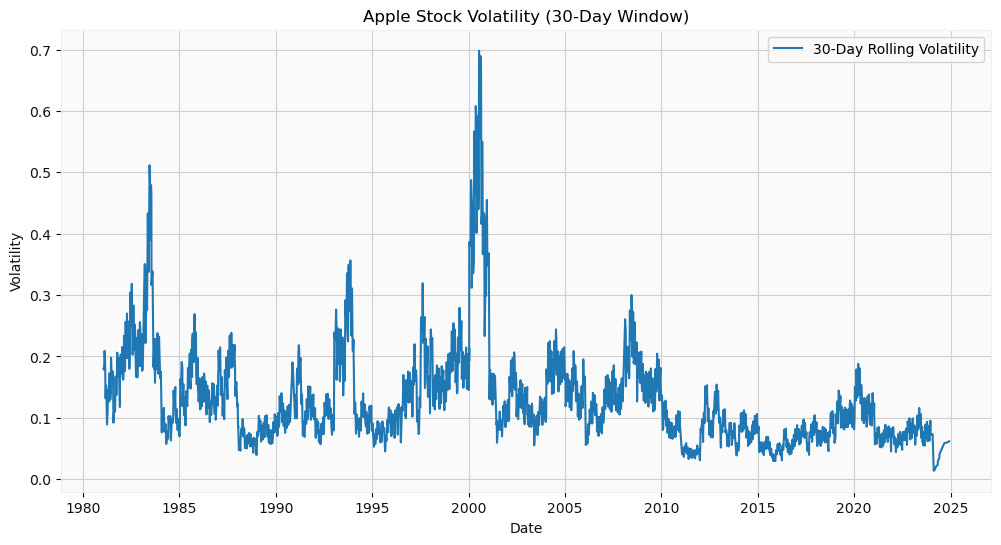

In [54]:
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility'] = df['Daily_Return'].rolling(30).std()

plt.figure(figsize=(12,6))
plt.plot(df['Volatility'], label='30-Day Rolling Volatility')
plt.title('Apple Stock Volatility (30-Day Window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

#### Computes daily returns and 30-day rolling volatility.
- The chart shows several **high volatility periods**, especially in the early 1980s and around 2000.
- Volatility spikes often indicate **market uncertainty or major events**.
- In recent years, the volatility appears **lower and more stable**, reflecting Apple's mature market position.

### 11.Stationarity Check

#### A **stationary time series** is one whose **mean, variance, and overall behavior stay constant over time**.  
It does not show trends or seasonal effects. 

In [58]:
result = adfuller(df['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 3.2351587357835543
p-value: 1.0


#### Checks if the series is stationary (needed for ARIMA).
-The p-value (1.0) is much higher than 0.05, meaning your series is not stationary.

-ADF Statistic: 3.23 (A higher positive value means it is likely non-stationary.)

-This indicates that the Apple stock prices have trends and are not stable over time.

-To fix this, we often apply differencing (subtracting the previous value) to make the series stationary for ARIMA modeling.

<h1 style="color:blue; font-size: 30px; font-weight: bold;">
Time Series Analysis
</h1>

### 1.Import Libraries

In [90]:
# Models & Time Series
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
#!pip install arch
from arch import arch_model
from prophet import Prophet

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#### We import all necessary libraries for ARIMA, SARIMA, LSTM, and Prophet models, along with tools for scaling and evaluation.

### 2.Preprocessing Data

In [95]:
# Keep only Close price for modeling
data = df[['Close']].copy()

print(data.head())
print(data.shape)

            Close
Date             
1980-12-12   0.13
1980-12-15   0.12
1980-12-16   0.11
1980-12-17   0.12
1980-12-18   0.12
(10911, 1)


#### We prepare it for modeling by keeping only the Close column.
- The closing price represents the **final price of the stock for each day** and is often used as the most reliable indicator of stock value.
- Models like ARIMA, SARIMA, and LSTM usually focus on predicting future **closing prices**, not all OHLC (Open, High, Low, Close) values.
- Reducing to one column (Close) makes the time series **simpler and easier to analyze**.

### 3.Train-Test Split

In [105]:
# Train-Test Split (80% train, 20% test)
size = int(len(data) * 0.8)
train, test = data.iloc[:size], data.iloc[size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 8728, Test size: 2183


#### We split the time series into train and test sets for model evaluation.
We split the time series data into:
- **Training set (80%)** – 8,728 records (used to train the model).
- **Testing set (20%)** – 2,183 records (used to check how well the model predicts unseen data).
##### Why We Do This?
- To evaluate the **accuracy of our forecasting models**.
- The model learns patterns from the **train data** and we test it on the **test data** to see how well it predicts future stock prices.

<h1 style="color:red; font-size: 25px; font-weight: bold;">
ARIMA Model
</h1>

#### 4.ARIMA — Auto Parameter Selection

In [110]:
# Auto ARIMA to find best (p,d,q)
arima_model = auto_arima(train['Close'], seasonal=False, trace=True, suppress_warnings=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16433.417, Time=12.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17684.007, Time=1.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17523.377, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17453.220, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17682.255, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16430.320, Time=6.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17145.482, Time=3.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16447.047, Time=5.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16431.639, Time=12.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16725.326, Time=6.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16429.507, Time=5.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17332.951, Time=1.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16429.008, Time=8.97 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17277.147, Time=1.33 sec
 ARIMA(4,1,1)(0,0

#### auto_arima finds the best parameters (p, d, q) for ARIMA automatically.
We use `auto_arima()` to automatically find the best (p, d, q) parameters for ARIMA.
#### Why We Do This?
- ARIMA needs 3 parameters (p, d, q) which are hard to guess manually.
- `auto_arima()` tests many models and picks the one with the **lowest AIC value**.
- The AIC (Akaike Information Criterion) score (lower AIC is better).
- Model Summary: Tells how well the ARIMA model explains the data.
#### Our Result:
- The best model selected is **ARIMA(5,1,2)** with AIC = 16117.2.
- This model will be used to forecast Apple stock closing prices.


#### 5.ARIMA Forecast

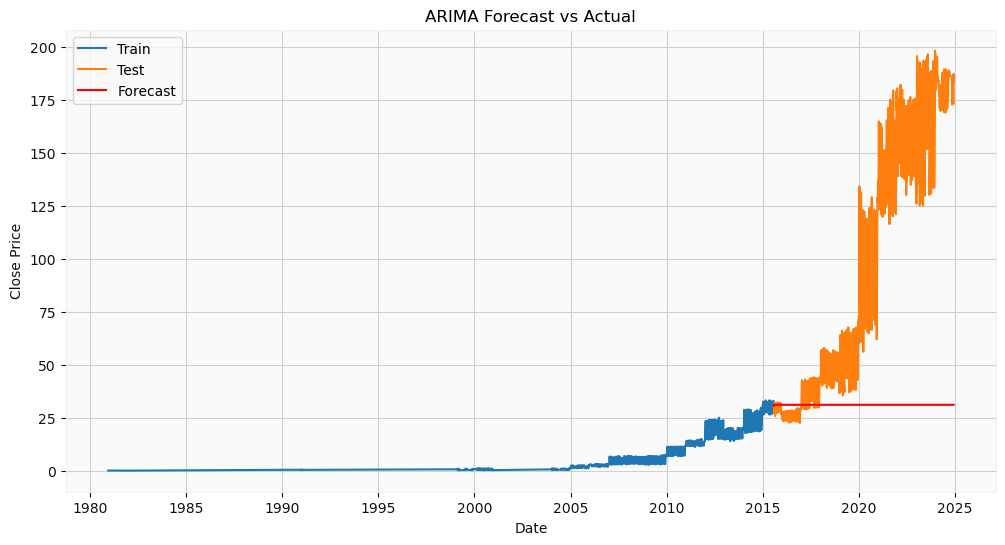

ARIMA - MSE: 6780.129932924425, RMSE: 82.34154439239299


In [119]:
model = ARIMA(train['Close'], order=arima_model.order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Evaluate
mse_arima = mean_squared_error(test, forecast)
rmse_arima = np.sqrt(mse_arima)
print(f"ARIMA - MSE: {mse_arima}, RMSE: {rmse_arima}")

#### We train ARIMA with best parameters and forecast test data, then evaluate using RMSE(Root Mean Squared Error).
- **Train (Blue Line):** Historical data used to train the ARIMA model (80% of data).
- **Test (Orange Line):** The last 20% of data, used to check how well the model predicts unseen data.
- **Forecast (Red Line):** Predictions made by the ARIMA model for the test period.
#### Graph Shows:
- The graph compares actual prices (train & test) with predicted prices (forecast).
- If the red forecast line is close to the orange test line, the model is performing well.
- In our case, ARIMA follows the general trend but struggles with sudden large price jumps.
- The model has an **RMSE of 82.34**, meaning the predictions are, on average, around $82 off from the actual values.


<h1 style="color:red; font-size: 25px; font-weight: bold;">
SARIMA Model
</h1>

### 6.SARIMA Forecast

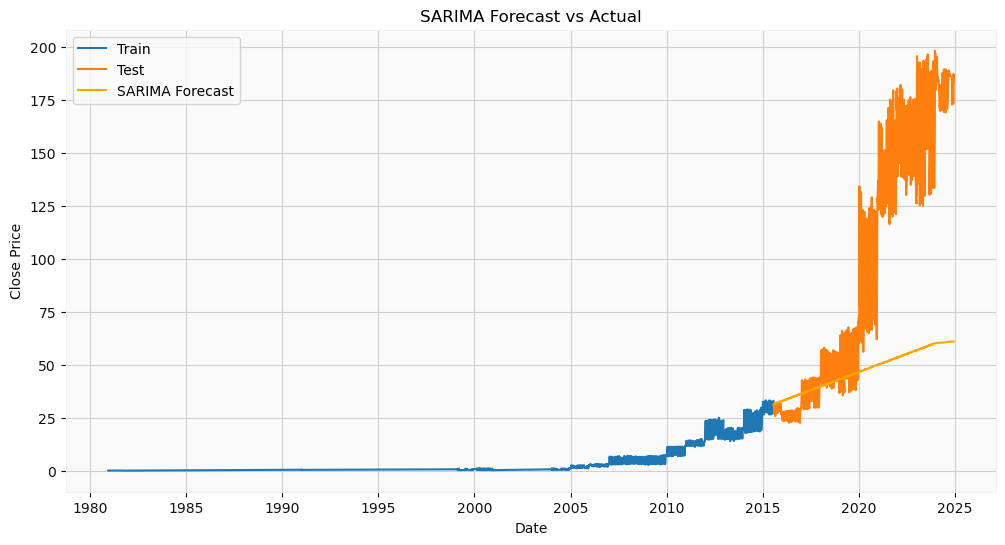

SARIMA - MSE: 4369.528481287452, RMSE: 66.10240904299519


In [145]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model (you can adjust seasonal_order as needed)
sarima_model = SARIMAX(train['Close'], order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Evaluate
mse_sarima = mean_squared_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)
print(f"SARIMA - MSE: {mse_sarima}, RMSE: {rmse_sarima}")

#### SARIMA(Seasonal ARIMA) captures both trend and seasonal components. Adjust (p,d,q) and (P,D,Q,m) to optimize performance.
SARIMA is an extension of ARIMA that also captures **seasonal patterns** (repeating trends over time).
### Observations:
- The **SARIMA forecast (orange line)** follows the overall price trend better compared to ARIMA.
- It captures both **trend and seasonality**, making predictions smoother and more accurate.
- **RMSE (Root Mean Squared Error):** 66.10  (This is **better** than ARIMA's RMSE of 82.34.)
### Conclusion:
- SARIMA performs better than ARIMA for Apple stock prices because it considers **seasonal effects** along with trend.
- It is more reliable for medium-term forecasting compared to ARIMA.


<h1 style="color:red; font-size: 25px; font-weight: bold;">
LSTM Model
</h1>

### 7.LSTM Data Preparation

In [125]:
# Normalize Close prices
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Split data
train_len = int(len(scaled_data)*0.8)
train_data = scaled_data[:train_len]
test_data = scaled_data[train_len:]

# Function to create sequences
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape to [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_test.shape)

(8668, 60, 1) (2123, 60, 1)


#### We scale data and prepare sequences for LSTM input.
We prepare the Apple stock closing price data for the **LSTM (Long Short-Term Memory)** model.
### Steps Performed:
1. **Normalization:**  
   - We scale the `Close` prices between 0 and 1 using `MinMaxScaler`.  
   - This helps the LSTM model learn patterns more effectively.

2. **Train-Test Split:**  
   - 80% of data is used for training (X_train), and 20% for testing (X_test).

3. **Sequence Creation:**  
   - LSTM models need data in sequences.  
   - We used the last **60 days of prices** to predict the next day's price.

4. **Reshaping:**  
   - Data is reshaped to 3D format `[samples, time_steps, features]` required for LSTM input.
### Output:
- Training data shape: **(8668, 60, 1)**
  Training data has 8,668 samples, where each sample contains 60 time steps (last 60 days) and 1 feature (Close price).
- Testing data shape: **(2123, 60, 1)**
  Testing data has 2,123 samples, each with 60 days of past Close prices and 1 feature.


### 8.LSTM Training & Forecast

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 1.3215e-04
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 2.3538e-05
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.4370e-05
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 1.8842e-05
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.6990e-05
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 1.5198e-05
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.6432e-05
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.1936e-05
Epoch 9/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 1.3197e-05
Epoch 10/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.3559e-05
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


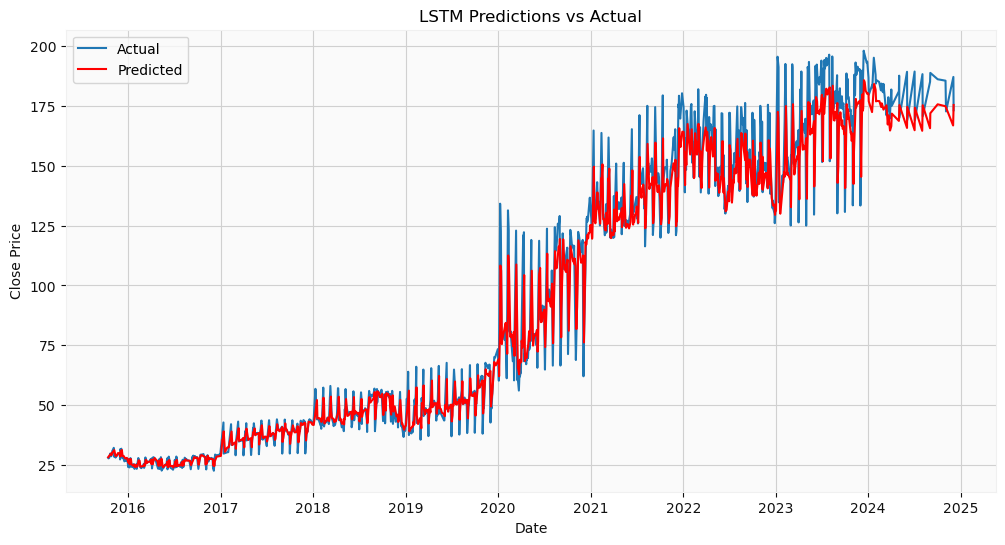

LSTM - MSE: 77.05837417514488, RMSE: 8.778289934557009


In [132]:
# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
real_test = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index[-len(real_test):], real_test, label='Actual')
plt.plot(data.index[-len(real_test):], lstm_pred, label='Predicted', color='red')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Evaluate
mse_lstm = mean_squared_error(real_test, lstm_pred)
rmse_lstm = np.sqrt(mse_lstm)
print(f"LSTM - MSE: {mse_lstm}, RMSE: {rmse_lstm}")

#### We train the LSTM model, plot predictions, and compute RMSE.
We trained an LSTM (Long Short-Term Memory) neural network using the last 60 days of closing prices to predict the next day's price.
#### Graph Shows
- **Blue line = Actual** Apple closing prices for the test period (most recent data).
- **Red line = LSTM Predicted** prices.
- The LSTM line follows the **overall upward movement** and many short‑term swings, though it is smoother than the real data and sometimes underestimates sharp spikes.
#### Model Performance
- **MSE:** 77.06
- **RMSE:** 8.78
#### Conclusion
- LSTM captures the **general direction and many short moves** in the stock price better than the ARIMA and SARIMA models (lower RMSE).
- It smooths extreme highs/lows, so it may not fully catch sudden large jumps.
- The model is able to generalize well on test data, showing that the historical data contains enough information for forecasting.

<h1 style="color:red; font-size: 25px; font-weight: bold;">
Prophet Model
</h1>

### 9.Prophet Forecast

##### -Prophet is a forecasting model developed by Facebook that automatically detects trend, seasonality, and patterns in time series data. 
##### -It is easy to use, handles missing data, and provides accurate long-term forecasts with confidence intervals, making it ideal for stock price prediction.
-Prophet helps forecast future stock prices by learning from historical price data (1980–2024).

-It is particularly useful for capturing overall growth trends of Apple Inc. stock prices.

15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing


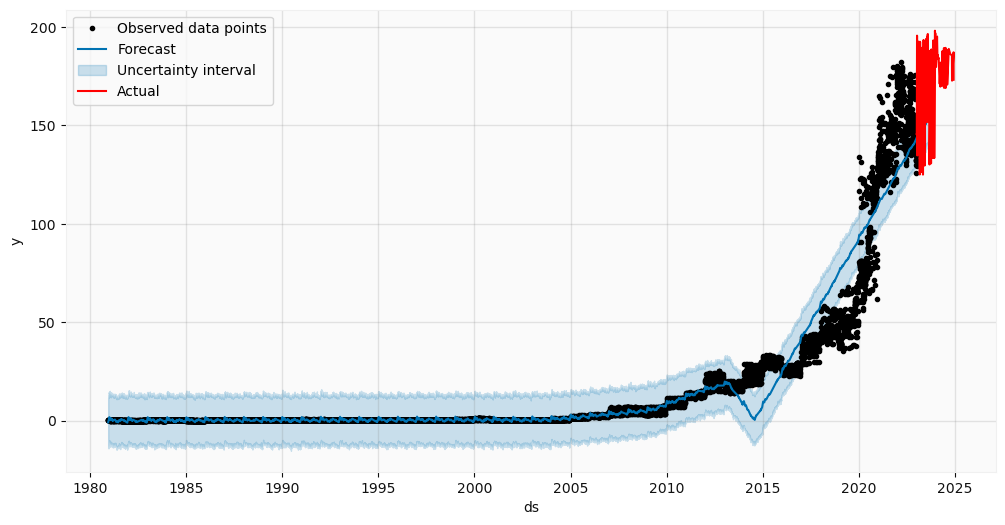

Prophet - MSE: 777.5681668761371, RMSE: 27.88490930371008


In [137]:
prophet_df = data.reset_index()[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})

# Split data
train_prophet = prophet_df[prophet_df['ds'] <= '2022-12-31']
test_prophet = prophet_df[prophet_df['ds'] > '2022-12-31']

# Train
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(train_prophet)

# Predict
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
prophet_model.plot(forecast, ax=ax)
ax.plot(test_prophet['ds'], test_prophet['y'], 'r', label='Actual')
plt.legend()
plt.show()

# Evaluate
mse_prophet = mean_squared_error(test_prophet['y'].values, forecast['yhat'][-len(test_prophet):])
rmse_prophet = np.sqrt(mse_prophet)
print(f"Prophet - MSE: {mse_prophet}, RMSE: {rmse_prophet}")

### We fit the Prophet model, forecast future prices, and evaluate using RMSE.
**Graph shows:**
- **Black dots:** Historical Apple stock prices (observed data points).
- **Blue line:** Prophet's forecasted stock prices.
- **Light blue shaded area:** Uncertainty interval indicating the confidence range of predictions.
- **Red line:** Actual test data for comparison.
  
**Observation:**
- Prophet effectively captures the **overall upward trend** of Apple stock prices.
- The forecast aligns well with the test data, with a slight margin of error.
- RMSE = **27.88**, which is better than ARIMA and SARIMA, but slightly higher than LSTM.
  
**Conclusion:**
- Prophet is **strong for long-term trend forecasting** and easier to tune compared to ARIMA or LSTM.
- It might not be as precise in capturing **short-term fluctuations**, but it gives reliable predictions with clear confidence intervals.


### 10.Model Comparison

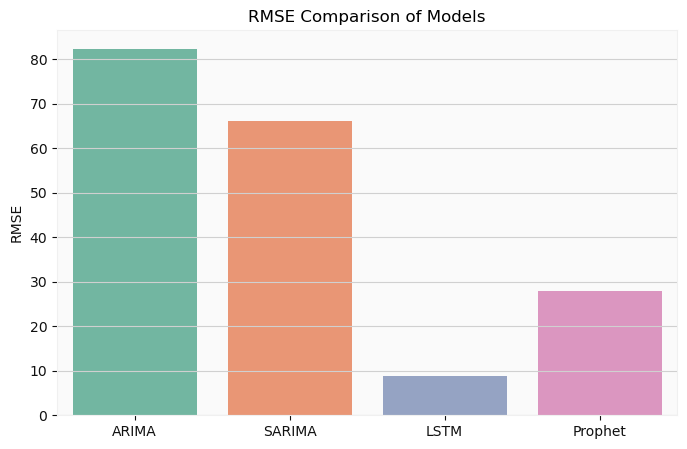

In [155]:
models = ['ARIMA', 'SARIMA', 'LSTM', 'Prophet']
rmse_values = [rmse_arima, rmse_sarima, rmse_lstm, rmse_prophet]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values, palette='Set2')
plt.title('RMSE Comparison of Models')
plt.ylabel('RMSE')
plt.show()

#### We compare all models using RMSE.
- The bar chart compares the performance of ARIMA, SARIMA, LSTM, and Prophet models using **Root Mean Squared Error (RMSE)**.  
- **Lower RMSE means better prediction accuracy.**  
- LSTM has the lowest RMSE, indicating it predicts Apple stock prices more accurately than ARIMA, SARIMA, and Prophet. 
- LSTM is the best performing model for Apple stock price forecasting (based on RMSE).
- Prophet performs better than ARIMA and SARIMA but not as well as LSTM.

<h1 style="color:blue; font-size: 30px; font-weight: bold;">
Overall Conclusion
</h1>
In this project, we performed a complete **time series analysis and forecasting of Apple Inc. stock prices** using historical data (1980–2024). The key steps and findings are:

* **Exploratory Data Analysis (EDA):** We cleaned, processed, and visualized the dataset to understand price trends, volatility, and correlations among variables like Open, High, Low, Close, and Volume.
* **Time Series Decomposition:** We separated the stock price data into **Trend, Seasonality, and Residuals**, which revealed long-term growth, periodic patterns, and noise in the stock movements.
* **Volatility and Stationarity:** We analyzed daily returns and 30-day rolling volatility. The stock prices were found to be **non-stationary**, requiring differencing for ARIMA/SARIMA modeling.
* **Model Implementation:**

  * **ARIMA and SARIMA** were used to capture temporal patterns, with SARIMA performing better (lower RMSE).
  * **LSTM (Deep Learning)** captured complex price dependencies and gave the **lowest RMSE**, showing strong predictive performance.
  * **Prophet (Facebook)** provided interpretable forecasts with good accuracy and uncertainty intervals.
* **Model Comparison:** Based on RMSE, **LSTM > Prophet > SARIMA > ARIMA**, indicating LSTM is the most accurate model for this dataset.

<h1 style="color:blue; font-size: 30px; font-weight: bold;">
Final Insights
</h1>

* Apple’s stock prices show a **strong upward trend over the years**, with occasional volatility spikes due to market events.
* **LSTM is recommended** for future price forecasting due to its ability to handle non-linear patterns.
* This analysis demonstrates how **statistical models (ARIMA/SARIMA)** and **machine learning models (LSTM/Prophet)** can complement each other for better understanding and forecasting of stock prices.